# Vous êtes Analyste quantitatif dans une société d'investissement. Votre Manager vous demande de créer une dataframe des prix journaliers de clôture des Actions françaises. Chaque secteur doit être représenté par la plus grande entreprise du CAC 40 (indice boursier représentant le marché financier en France) selon la capitalisation boursière. Vous devez récupérer les données depuis le 1er Janvier 2015 jusqu'à ce jour afin de permettre une actualisation automatique des informations.

Ayant commencé par une recherche internet sur l'indice du CAC 40, vous avez obtenu les informations ci-dessous :

Le CAC (Cotation Assistée en Continu) 40 est le principal indice de la bourse de Paris.

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
pip install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [61]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader, get_quote_yahoo
import seaborn as sns

import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_regression

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error, r2_score

In [5]:
cac40 = pd.read_html('https://en.wikipedia.org/wiki/CAC_40')[4]
cac40

,Company,Sector,GICS Sub-Industry,Ticker
0,Accor,Consumer Services,"Hotels, Restaurants & Leisure",AC.PA
1,Air Liquide,Basic Materials,Industrial Gases,AI.PA
2,Airbus,Industrials,Aerospace & Defense,AIR.PA
3,ArcelorMittal,Basic Materials,Steel,MT.AS
4,Axa,Financial Services,Life & Health Insurance,CS.PA
5,BNP Paribas,Financial Services,Diversified Banks,BNP.PA
6,Bouygues,Industrials,Construction & Engineering,EN.PA
7,Capgemini,Technology,IT Consulting & Other Services,CAP.PA
8,Carrefour,Consumer Defensive,Hypermarkets & Super Centers,CA.PA
9,Crédit Agricole,Financial Services,Regional Banks,ACA.PA


Etant donné que vous voulez récupérer les prix journaliers de la plus grande entreprise, par secteur, en matière de capitalisation boursière, il faudra avoir la capitalisation boursière de chacune des entreprises de cet indice.

In [6]:
tickers=cac40['Ticker'].to_list()

In [7]:
tickers


['AC.PA',
 'AI.PA',
 'AIR.PA',
 'MT.AS',
 'CS.PA',
 'BNP.PA',
 'EN.PA',
 'CAP.PA',
 'CA.PA',
 'ACA.PA',
 'BN.PA',
 'DSY.PA',
 'EDEN.PA',
 'ENGI.PA',
 'EL.PA',
 'ERF.PA',
 'RMS.PA',
 'KER.PA',
 'OR.PA',
 'LR.PA',
 'MC.PA',
 'ML.PA',
 'ORA.PA',
 'RI.PA',
 'PUB.PA',
 'RNO.PA',
 'SAF.PA',
 'SGO.PA',
 'SAN.PA',
 'SU.PA',
 'GLE.PA',
 'STLAP.PA',
 'STMPA.PA',
 'TEP.PA',
 'HO.PA',
 'TTE.PA',
 'URW.PA',
 'VIE.PA',
 'DG.PA',
 'VIV.PA']

In [8]:
from pandas_datareader import DataReader, get_quote_yahoo
# get_quote_yahoo va nous permettre de recuperer les capitalistions boursières

In [9]:
import yfinance as yf

In [10]:
# Récupérer les données pour chaque ticker
# Initialiser un dictionnaire pour stocker les capitalisations boursières
market_caps = {}

for ticker in tickers:
    data = yf.Ticker(ticker)
    market_cap = data.info.get("marketCap")
    market_caps[ticker] = market_cap

# Afficher les résultats
print("Capitalisations boursières :")
for ticker, cap in market_caps.items():
    print(f"{ticker}: {cap}")

Capitalisations boursières :
AC.PA: 11864195072
AI.PA: 95620694016
AIR.PA: 131022323712
MT.AS: 18309554176
CS.PA: 80597237760
BNP.PA: 72550883328
EN.PA: 11718715392
CAP.PA: 26797205504
CA.PA: 8749207552
ACA.PA: 43513020416
BN.PA: 42489511936
DSY.PA: 47835754496
EDEN.PA: 7679615488
ENGI.PA: 38049304576
EL.PA: 117056086016
ERF.PA: 9236838400
RMS.PA: 277186379776
KER.PA: 32066551808
OR.PA: 192298893312
LR.PA: 25372973056
MC.PA: 369835638784
ML.PA: 24073943040
ORA.PA: 27664306176
RI.PA: 27783043072
PUB.PA: 25421453312
RNO.PA: 14271876096
SAF.PA: 98255978496
SGO.PA: 43845341184
SAN.PA: 127941394432
SU.PA: 138281009152
GLE.PA: 24229468160
STLAP.PA: 37126754304
STMPA.PA: 21899446272
TEP.PA: 5172193792
HO.PA: 31351267328
TTE.PA: 125818626048
URW.PA: 11167929344
VIE.PA: 20113952768
DG.PA: 59322331136
VIV.PA: 2541022208


In [11]:
#cac40['Market_capitalization']=market_caps.values
# Ajouter les données au DataFrame
cac40['Market_capitalization'] = cac40['Ticker'].map(market_caps)

# Convertir en milliards
cac40['Market_capitalization'] = cac40['Market_capitalization'] / 1_000_000_000


In [12]:
cac40

,Company,Sector,GICS Sub-Industry,Ticker,Market_capitalization
0,Accor,Consumer Services,"Hotels, Restaurants & Leisure",AC.PA,11.864195
1,Air Liquide,Basic Materials,Industrial Gases,AI.PA,95.620694
2,Airbus,Industrials,Aerospace & Defense,AIR.PA,131.022324
3,ArcelorMittal,Basic Materials,Steel,MT.AS,18.309554
4,Axa,Financial Services,Life & Health Insurance,CS.PA,80.597238
5,BNP Paribas,Financial Services,Diversified Banks,BNP.PA,72.550883
6,Bouygues,Industrials,Construction & Engineering,EN.PA,11.718715
7,Capgemini,Technology,IT Consulting & Other Services,CAP.PA,26.797206
8,Carrefour,Consumer Defensive,Hypermarkets & Super Centers,CA.PA,8.749208
9,Crédit Agricole,Financial Services,Regional Banks,ACA.PA,43.513020


In [13]:
cac40.set_index('Ticker',inplace=True)# definir la colonne Ticker comme indices de lignes

In [14]:
cac40.head()

,Company,Sector,GICS Sub-Industry,Market_capitalization
Ticker,,,,
AC.PA,Accor,Consumer Services,"Hotels, Restaurants & Leisure",11.864195
AI.PA,Air Liquide,Basic Materials,Industrial Gases,95.620694
AIR.PA,Airbus,Industrials,Aerospace & Defense,131.022324
MT.AS,ArcelorMittal,Basic Materials,Steel,18.309554
CS.PA,Axa,Financial Services,Life & Health Insurance,80.597238


In [15]:
composantes= cac40.groupby('Sector')['Market_capitalization'].nlargest(1)

In [16]:
composantes

Sector                  Ticker 
Basic Materials         AI.PA       95.620694
Communication Services  ORA.PA      27.664306
Consumer Cyclical       MC.PA      369.835639
Consumer Defensive      OR.PA      192.298893
Consumer Services       AC.PA       11.864195
Energy                  TTE.PA     125.818626
Financial Services      CS.PA       80.597238
Healthcare              SAN.PA     127.941394
Industrials             SU.PA      138.281009
Real Estate             URW.PA      11.167929
Technology              DSY.PA      47.835754
Utilities               ENGI.PA     38.049305
Name: Market_capitalization, dtype: float64

In [17]:
#Tranformer ce resultat en un dataframe
composantes= composantes.reset_index()
composantes

,Sector,Ticker,Market_capitalization
0,Basic Materials,AI.PA,95.620694
1,Communication Services,ORA.PA,27.664306
2,Consumer Cyclical,MC.PA,369.835639
3,Consumer Defensive,OR.PA,192.298893
4,Consumer Services,AC.PA,11.864195
5,Energy,TTE.PA,125.818626
6,Financial Services,CS.PA,80.597238
7,Healthcare,SAN.PA,127.941394
8,Industrials,SU.PA,138.281009
9,Real Estate,URW.PA,11.167929


In [18]:
composantes.sort_values(by= 'Market_capitalization',ascending= False)

,Sector,Ticker,Market_capitalization
2,Consumer Cyclical,MC.PA,369.835639
3,Consumer Defensive,OR.PA,192.298893
8,Industrials,SU.PA,138.281009
7,Healthcare,SAN.PA,127.941394
5,Energy,TTE.PA,125.818626
0,Basic Materials,AI.PA,95.620694
6,Financial Services,CS.PA,80.597238
10,Technology,DSY.PA,47.835754
11,Utilities,ENGI.PA,38.049305
1,Communication Services,ORA.PA,27.664306


In [19]:
symbols=composantes['Ticker'].to_list()

In [20]:
symbols

['AI.PA',
 'ORA.PA',
 'MC.PA',
 'OR.PA',
 'AC.PA',
 'TTE.PA',
 'CS.PA',
 'SAN.PA',
 'SU.PA',
 'URW.PA',
 'DSY.PA',
 'ENGI.PA']

A présent que nous connaissant les plus grandes entreprises du CAC40 par secteur ainsi que leurs symboles, nous allons importer les prix quotidiens de chaque Action à partir de Yahoo Finance.

In [21]:
# Télécharger les prix ajustés de clôture
stocks_prices = yf.download(
    tickers=symbols,         # Liste de tickers
    start="2000-01-01",      # Date de début
    end=None,                # Date de fin (None = aujourd'hui)
    progress=False,          # Désactiver l'affichage de progression
    group_by="ticker",       # Organiser les données par ticker
)


In [22]:
# Si tu veux uniquement les colonnes "Adj Close"
stocks_prices = stocks_prices.loc[:, (slice(None), 'Adj Close')]

stocks_prices.head()

Ticker,AC.PA,ORA.PA,ENGI.PA,TTE.PA,CS.PA,AI.PA,URW.PA,SU.PA,SAN.PA,OR.PA,DSY.PA,MC.PA
Price,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close
Date,,,,,,,,,,,,
2000-01-03 00:00:00+00:00,5.152411,32.842163,10.150024,9.740067,5.963916,14.345432,NaN,19.236559,17.602268,53.111515,5.606574,56.212452
2000-01-04 00:00:00+00:00,4.991400,31.087238,9.972287,9.385880,5.744655,13.708799,NaN,18.554754,16.507599,49.341873,5.054162,50.895050
2000-01-05 00:00:00+00:00,4.991400,29.457666,9.832638,9.149758,5.656950,13.581474,NaN,17.775549,15.811392,47.659004,4.662526,49.173222
2000-01-06 00:00:00+00:00,5.010722,29.081606,9.965941,8.884120,5.613099,14.557645,NaN,18.676498,16.420031,49.476505,4.720239,48.616188
2000-01-07 00:00:00+00:00,5.173881,29.959072,9.775511,8.928394,5.788508,14.379387,NaN,19.017403,17.295765,50.486221,4.946977,48.616188


SUPER TRAVAIL ! Vous venez d'obtenir la dataframe telle que souhaitée par votre Manager qui sera très content. Votre code est aussi réutilisable ce qui permettra d'actualiser les informations au cas où la situation du marché fiancier en France évolue.

L'objectif 1 de ce chapitre étant atteint, passons à l'objectif 2.

In [23]:
stocks_prices.tail()

Ticker,AC.PA,ORA.PA,ENGI.PA,TTE.PA,CS.PA,AI.PA,URW.PA,SU.PA,SAN.PA,OR.PA,DSY.PA,MC.PA
Price,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close,Adj Close
Date,,,,,,,,,,,,
2025-01-21 00:00:00+00:00,48.320000,10.325,15.695,56.639999,35.250000,160.860001,75.040001,262.850006,99.019997,341.200012,35.060001,701.299988
2025-01-22 00:00:00+00:00,49.049999,10.230,15.525,56.380001,35.720001,162.399994,74.400002,269.799988,98.849998,349.649994,35.820000,713.799988
2025-01-23 00:00:00+00:00,48.580002,10.205,15.500,56.139999,36.119999,161.720001,75.720001,271.700012,99.889999,354.549988,36.000000,720.599976
2025-01-24 00:00:00+00:00,48.980000,10.155,15.500,55.840000,35.900002,163.759995,76.800003,270.649994,100.160004,358.450012,36.820000,734.099976
2025-01-27 00:00:00+00:00,48.660000,10.360,15.685,55.810001,36.470001,165.880005,78.300003,245.550003,102.059998,359.899994,36.570000,740.400024


#  Machine Learning pour la modélisation des séries temporelles

Parmi les approches traditionnelles de modélisation des séries temporelles, les modèles ARIMA (Autoregressive integrated moving average) sont les plus utilisés. Les modèles ARIMA ont l'avantage d'être faciles à comprendre et interprétables. Mais, tout comme les autres approches traditionnelles de modélisation statistique des séries temporelles, ils ont des limites d'efficacité pour des problèmes beaucoup plus complexes. Pour ces problèmes complexes, on constate de plus en plus, l'utilisation du Machine Learning dans la prévision de séries temporelles.

 L'objectif est d'utiliser divers modèles de régression basés sur l'apprentissage supervisé pour prédire le cours de l'action LVMH à l'aide d'actifs corrélés et de ses propres données historiques.

La plupart du temps en modélisation financière, on ne prédit pas directement le prix d'une action mais on cherche plutôt à prédire le rendement. Ici, nous allons définir notre variable cible comme étant le rendement journalier de l'action LVMH. L'ensemble des variables indépendantes que nous utiliserons est constitué :

des rendements décalés de 5 jours des autres actions de la dataframe stocks_price (Chapitre 2) ;

des rendements décalés de 5, 15, 30 et 60 jours de l'action LVMH.

In [97]:
# variable cible

period = 5

y = stocks_prices['MC.PA'].shift(-period).pct_change(period)

y.name = 'LVMH_5d_close_future_pct'

y.head()

Price,Adj Close
Date,
2000-01-03 00:00:00+00:00,NaN
2000-01-04 00:00:00+00:00,NaN
2000-01-05 00:00:00+00:00,NaN
2000-01-06 00:00:00+00:00,NaN
2000-01-07 00:00:00+00:00,NaN


In [26]:
# Suppression des valeurs manquantes

y.dropna(inplace = True)
y


Price,Adj Close
Date,
2000-01-10 00:00:00+00:00,0.161919
2000-01-11 00:00:00+00:00,0.093137
2000-01-12 00:00:00+00:00,0.032864
2000-01-13 00:00:00+00:00,-0.019911
2000-01-14 00:00:00+00:00,-0.078723
...,...
2025-01-21 00:00:00+00:00,0.055754
2025-01-22 00:00:00+00:00,0.037265
2025-01-23 00:00:00+00:00,0.027477


Ce code calcule des indicateurs financiers basés sur les moyennes mobiles simples (SMA) et exponentielles (EMA) pour l'action MC.PA (LVMH, selon les tickers boursiers). Ces indicateurs sont ensuite divisés par le prix de clôture de l'action pour les normaliser.

Contrairement à la SMA, l'EMA donne plus de poids aux prix récents.

In [30]:
X_SMA_EMA=pd.DataFrame()
for n in [5, 14, 30, 50, 200]:

    # Création des indicateurs de moyenne mobile et division par le prix de clôture
    X_SMA_EMA['sma' + str(n)] = (stocks_prices['MC.PA'].rolling(window=n).mean()) / stocks_prices['MC.PA']
    
    # Création des indicateurs de moyenne mobile exponentielle et division par le prix de clôture
    X_SMA_EMA['ema' + str(n)] = (stocks_prices['MC.PA'].ewm(span=n, min_periods=n).mean()) / stocks_prices['MC.PA']


Le DataFrame X_SMA_EMA contient désormais 10 colonnes :

sma5, sma14, sma30, sma50, sma200: Moyennes mobiles simples normalisées.
ema5, ema14, ema30, ema50, ema200: Moyennes mobiles exponentielles normalisées.

rolling().mean() (pour les moyennes mobiles simples)

ewm().mean() (pour les moyennes mobiles exponentielles)

Définition : L'EMA attribue un poids plus élevé aux prix récents, ce qui la rend plus réactive aux changements de marché.

Formule simplifiée :

EMA
𝑡
=
𝛼
⋅
Prix
𝑡
+
(
1
−
𝛼
)
⋅
EMA
𝑡
−1

 
Où :

𝛼
 est egal à
2/
𝑛
+
1

​
  (facteur de lissage, 
𝑛
n est la période choisie).
EMA
𝑡
−
1
EMA 
t−1
​
  est la valeur de l'EMA précédente.
Caractéristiques :

Réagit plus vite que la SMA aux mouvements récents des prix.
Les prix plus anciens ont une influence moindre.
Avantage : Idéale pour suivre les tendances de court terme ou détecter rapidement les changements.

Inconvénient : Peut générer plus de faux signaux en raison de sa sensibilité aux fluctuations.

In [31]:
X_SMA_EMA

,sma5,ema5,sma14,ema14,sma30,ema30,sma50,ema50,sma200,ema200
Date,,,,,,,,,,
2000-01-03 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07 00:00:00+00:00,1.042916,1.019135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-01-21 00:00:00+00:00,0.971681,0.974567,0.932870,0.944096,0.918589,0.919945,0.885376,0.906989,0.953477,0.941340
2025-01-22 00:00:00+00:00,0.976128,0.971667,0.924379,0.937222,0.906398,0.910039,0.873260,0.895376,0.936346,0.925603
2025-01-23 00:00:00+00:00,0.973883,0.974998,0.926490,0.937927,0.900990,0.907810,0.868535,0.891361,0.927190,0.917696


In [33]:
# RSI de de 5, 14, 30, 50, et 200 jours
def RSI(series, period):
    # Calcul des variations journalières
    delta = series.diff()
    
    # Séparation des gains et pertes
    gain = delta.clip(lower=0)  # Garde uniquement les gains (Delta > 0)
    loss = -delta.clip(upper=0)  # Garde uniquement les pertes (Delta < 0)
    
    # Moyennes mobiles exponentielles (EMA)
    avg_gain = gain.ewm(span=period, adjust=False).mean()
    avg_loss = loss.ewm(span=period, adjust=False).mean()
    
    # Relative Strength (RS)
    rs = avg_gain / avg_loss
    
    # RSI final
    rsi = 100 - (100 / (1 + rs))
    
    return rsi


for n in [5, 14, 30, 50, 200]:
    X_RSI['RSI' + str(n)] = RSI(stocks_prices['MC.PA'], n)
    
X_RSI

,RSI5,RSI14,RSI30,RSI50,RSI200
Date,,,,,
2000-01-10 00:00:00+00:00,34.413544,7.861260,3.057972,1.714349,0.396159
2000-01-11 00:00:00+00:00,47.470078,11.717084,4.560171,2.551586,0.587696
2000-01-12 00:00:00+00:00,68.900123,20.567809,8.073970,4.505346,1.031282
2000-01-13 00:00:00+00:00,83.491937,31.940077,13.018699,7.299547,1.671408
2000-01-14 00:00:00+00:00,88.900135,38.924903,16.348618,9.213655,2.114122
...,...,...,...,...,...
2025-01-21 00:00:00+00:00,78.128197,72.310356,67.406415,63.234345,52.330009
2025-01-22 00:00:00+00:00,84.312886,75.759026,69.751012,65.009183,52.995577
2025-01-23 00:00:00+00:00,87.253916,77.516708,70.965551,65.940143,53.353433


In [38]:
lmvh_volume=yf.download(
    tickers='MC.PA',         
    start="2000-01-01",      # Date de début
    end=None,                # Date de fin (None = aujourd'hui)
    progress=False, 
     group_by="ticker",# Désactiver l'affichage de progression
                       # Organiser les données par ticker
)
lmvh_volume.head()

Ticker                         MC.PA                                   \
Price                           Open       High        Low      Close   
Date                                                                    
2000-01-03 00:00:00+00:00  91.779999  93.180000  88.199997  88.800003   
2000-01-04 00:00:00+00:00  90.800003  90.800003  80.400002  80.400002   
2000-01-05 00:00:00+00:00  79.000000  79.800003  76.000000  77.680000   
2000-01-06 00:00:00+00:00  77.599998  77.599998  74.459999  76.800003   
2000-01-07 00:00:00+00:00  76.400002  76.800003  74.019997  76.800003   

Ticker                                         
Price                      Adj Close   Volume  
Date                                           
2000-01-03 00:00:00+00:00  56.212448   615855  
2000-01-04 00:00:00+00:00  50.895050  1691700  
2000-01-05 00:00:00+00:00  49.173237  1563735  
2000-01-06 00:00:00+00:00  48.616184  1641215  
2000-01-07 00:00:00+00:00  48.616184  1360530

In [46]:
lmvh_volume=lmvh_volume.loc[:, (slice(None), 'Volume')]
lmvh_volume.head()


Ticker,MC.PA
Price,Volume
Date,
2000-01-03 00:00:00+00:00,615855
2000-01-04 00:00:00+00:00,1691700
2000-01-05 00:00:00+00:00,1563735
2000-01-06 00:00:00+00:00,1641215
2000-01-07 00:00:00+00:00,1360530


In [48]:
# Création d'un DataFrame vide pour stocker les caractéristiques liées au volume d'actions LVMH
X_Volume = pd.DataFrame()

# Calcul du changement en pourcentage du volume ajusté d'une journée à l'autre
# 'lvmh_volume' contient les volumes d'actions LVMH sur les jours
# pct_change() calcule la variation en pourcentage entre le jour actuel et le jour précédent
X_Volume['Adj_Volume_1d_change'] = lmvh_volume.pct_change()

# Affichage de la colonne 'Adj_Volume_1d_change' pour observer les résultats
# Cela affiche les changements en pourcentage du volume des actions LVMH de chaque jour par rapport au jour précédent
X_Volume['Adj_Volume_1d_change']


Date
2000-01-03 00:00:00+00:00         NaN
2000-01-04 00:00:00+00:00    1.746913
2000-01-05 00:00:00+00:00   -0.075643
2000-01-06 00:00:00+00:00    0.049548
2000-01-07 00:00:00+00:00   -0.171023
                               ...   
2025-01-21 00:00:00+00:00    0.245806
2025-01-22 00:00:00+00:00    0.185273
2025-01-23 00:00:00+00:00   -0.068763
2025-01-24 00:00:00+00:00    0.238964
2025-01-27 00:00:00+00:00   -0.605128
Name: Adj_Volume_1d_change, Length: 6444, dtype: float64

In [49]:
# Calcul de la moyenne mobile simple (SMA) des changements de volume sur une fenêtre de 5 jours
# 'rolling(window=5)' crée une fenêtre glissante de 5 jours
# 'mean()' calcule la moyenne des valeurs dans cette fenêtre pour chaque jour
X_Volume['Adj_Volume_1d_change_SMA'] = (X_Volume['Adj_Volume_1d_change'].rolling(window=5).mean())

# Affichage du DataFrame avec la nouvelle colonne 'Adj_Volume_1d_change_SMA'
# Cette colonne représente la moyenne mobile simple des changements de volume sur les 5 derniers jours
X_Volume


,Adj_Volume_1d_change,Adj_Volume_1d_change_SMA
Date,,
2000-01-03 00:00:00+00:00,NaN,NaN
2000-01-04 00:00:00+00:00,1.746913,NaN
2000-01-05 00:00:00+00:00,-0.075643,NaN
2000-01-06 00:00:00+00:00,0.049548,NaN
2000-01-07 00:00:00+00:00,-0.171023,NaN
...,...,...
2025-01-21 00:00:00+00:00,0.245806,0.133171
2025-01-22 00:00:00+00:00,0.185273,0.143606
2025-01-23 00:00:00+00:00,-0.068763,-0.077835


In [50]:
# Création des rendements décalés de 5 jours des autres actions dans le DataFrame 'stocks_prices'

# pd.concat() va concaténer les colonnes générées pour chaque action différente de 'MC.PA' (LVMH)
# Pour chaque action (stk) dans 'symbols' sauf 'MC.PA', on applique :
# - .shift(period) : Décale les prix de l'action de 'period' jours. Cela permet de comparer les prix actuels avec ceux du passé.
# - .pct_change() : Calcule le rendement journalier en pourcentage en utilisant les prix décalés.

X_lags_others_stocks = pd.concat(
    [stocks_prices[stk].shift(5).pct_change() for stk in symbols if stk != 'MC.PA'],  # Rendements décalés de 5 jours
    axis = 1  # On concatène les colonnes sur l'axe des colonnes
)

# Renommage des colonnes pour inclure le nom de l'action suivi de '_DT' pour indiquer les rendements décalés
X_lags_others_stocks.columns = [i + '_DT' for i in symbols if i != 'MC.PA']

# Suppression des lignes contenant des valeurs manquantes (NaN)
# Après le calcul du rendement décalé, certaines lignes peuvent contenir NaN si l'on déplace trop de valeurs.
X_lags_others_stocks.dropna(inplace=True)

# Affichage du DataFrame contenant les rendements décalés des autres actions
X_lags_others_stocks


,AI.PA_DT,ORA.PA_DT,OR.PA_DT,AC.PA_DT,TTE.PA_DT,CS.PA_DT,SAN.PA_DT,SU.PA_DT,URW.PA_DT,DSY.PA_DT,ENGI.PA_DT
Date,,,,,,,,,,,
2023-04-24 00:00:00+00:00,0.009845,0.010481,0.005943,0.014157,0.000170,-0.013234,0.004312,0.006382,-0.022472,-0.001456,0.008752
2023-04-25 00:00:00+00:00,0.005124,0.006153,0.002718,0.010470,-0.001362,0.017646,-0.010734,0.004756,-0.008323,0.004376,0.005127
2023-04-26 00:00:00+00:00,0.005223,0.001572,-0.004714,-0.009105,-0.009889,0.015433,0.005721,0.003419,-0.005396,-0.010298,0.009678
2023-04-27 00:00:00+00:00,0.003835,0.002268,0.017168,-0.010139,-0.008438,0.000000,-0.004512,0.000524,-0.015069,-0.005736,-0.001166
2023-04-28 00:00:00+00:00,0.003697,0.004003,0.030381,0.004481,0.002084,-0.000512,0.013596,-0.000655,-0.005508,0.007111,0.003372
...,...,...,...,...,...,...,...,...,...,...,...
2025-01-21 00:00:00+00:00,-0.003707,0.008345,-0.005329,0.014737,-0.005722,0.005376,-0.018216,0.007661,-0.002243,0.001472,-0.004748
2025-01-22 00:00:00+00:00,0.003207,0.016855,0.008725,0.006525,0.005935,0.021985,0.027671,0.008203,0.030635,-0.002058,0.005407
2025-01-23 00:00:00+00:00,0.012020,0.007444,0.028528,-0.003555,0.025925,0.019767,0.021499,0.009526,0.002182,0.011193,0.001898


In [51]:
# Ensemble total des prédicteurs

X = pd.concat([X_SMA_EMA, X_RSI, X_Volume, X_lags_others_stocks], axis = 1)

X

,sma5,ema5,sma14,ema14,sma30,ema30,sma50,ema50,sma200,ema200,...,ORA.PA_DT,OR.PA_DT,AC.PA_DT,TTE.PA_DT,CS.PA_DT,SAN.PA_DT,SU.PA_DT,URW.PA_DT,DSY.PA_DT,ENGI.PA_DT
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07 00:00:00+00:00,1.042916,1.019135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-21 00:00:00+00:00,0.971681,0.974567,0.932870,0.944096,0.918589,0.919945,0.885376,0.906989,0.953477,0.941340,...,0.008345,-0.005329,0.014737,-0.005722,0.005376,-0.018216,0.007661,-0.002243,0.001472,-0.004748
2025-01-22 00:00:00+00:00,0.976128,0.971667,0.924379,0.937222,0.906398,0.910039,0.873260,0.895376,0.936346,0.925603,...,0.016855,0.008725,0.006525,0.005935,0.021985,0.027671,0.008203,0.030635,-0.002058,0.005407
2025-01-23 00:00:00+00:00,0.973883,0.974998,0.926490,0.937927,0.900990,0.907810,0.868535,0.891361,0.927190,0.917696,...,0.007444,0.028528,-0.003555,0.025925,0.019767,0.021499,0.009526,0.002182,0.011193,0.001898


In [94]:

# Combiner les features avec la variable cible
X = pd.concat([X_SMA_EMA, X_RSI, X_Volume, X_lags_others_stocks], axis=1)

# Ajouter la variable cible 'y' dans le DataFrame final
clean_dataset = pd.concat([X, y], axis=1).dropna()

# Afficher les premières lignes du DataFrame
clean_dataset.head()

,sma5,ema5,sma14,ema14,sma30,ema30,sma50,ema50,sma200,ema200,...,OR.PA_DT,AC.PA_DT,TTE.PA_DT,CS.PA_DT,SAN.PA_DT,SU.PA_DT,URW.PA_DT,DSY.PA_DT,ENGI.PA_DT,Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-24 00:00:00+00:00,0.989379,0.990372,0.962821,0.966600,0.927269,0.940573,0.914523,0.919283,0.797427,0.821465,...,0.005943,0.014157,0.000170,-0.013234,0.004312,0.006382,-0.022472,-0.001456,0.008752,-0.029385
2023-04-25 00:00:00+00:00,0.999816,0.997739,0.973047,0.976328,0.936594,0.949947,0.922485,0.928010,0.804088,0.828362,...,0.002718,0.010470,-0.001362,0.017646,-0.010734,0.004756,-0.008323,0.004376,0.005127,-0.011468
2023-04-26 00:00:00+00:00,1.015182,1.009130,0.991139,0.993017,0.955372,0.967388,0.938869,0.945092,0.818523,0.843186,...,-0.004714,-0.009105,-0.009889,0.015433,0.005721,0.003419,-0.005396,-0.010298,0.009678,-0.001942
2023-04-27 00:00:00+00:00,1.010377,1.004783,0.992398,0.992280,0.956667,0.967738,0.938711,0.945486,0.818485,0.843128,...,0.017168,-0.010139,-0.008438,0.000000,-0.004512,0.000524,-0.015069,-0.005736,-0.001166,-0.000228
2023-04-28 00:00:00+00:00,1.012147,1.007880,1.003312,0.999332,0.967283,0.976160,0.946544,0.953986,0.825664,0.850535,...,0.030381,0.004481,0.002084,-0.000512,0.013596,-0.000655,-0.005508,0.007111,0.003372,0.015499


In [95]:
clean_dataset=pd.concat([y,X],axis=1).dropna()
clean_dataset=clean_dataset.rename(columns={'Adj Close':'LVMH_5d_close_future_pct'})


In [96]:
# Création de variables fictives (dummy variables) pour les jours de la semaine
# .dayofweek renvoie l'indice du jour de la semaine, où 0 = lundi, 1 = mardi, etc.
days_of_week = pd.get_dummies(
    clean_dataset.index.dayofweek,  # Utilise l'index (la date) pour extraire les jours de la semaine
    prefix = 'weekday',  # Le préfixe utilisé pour les noms des nouvelles colonnes
    drop_first = True  # Ne garde pas la première colonne (pour éviter la multicolinéarité)
)

# Assigner à l'index des jours de la semaine l'index de clean_dataset pour que les nouvelles variables aient la même indexation temporelle
days_of_week.index = clean_dataset.index

# Concaténation des jours de la semaine avec le dataset initial
clean_dataset = pd.concat([clean_dataset, days_of_week], axis = 1)

# Affichage du dataset avec les nouvelles variables
clean_dataset


,LVMH_5d_close_future_pct,sma5,ema5,sma14,ema14,sma30,ema30,sma50,ema50,sma200,...,CS.PA_DT,SAN.PA_DT,SU.PA_DT,URW.PA_DT,DSY.PA_DT,ENGI.PA_DT,weekday_1,weekday_2,weekday_3,weekday_4
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-24 00:00:00+00:00,-0.029385,0.989379,0.990372,0.962821,0.966600,0.927269,0.940573,0.914523,0.919283,0.797427,...,-0.013234,0.004312,0.006382,-0.022472,-0.001456,0.008752,False,False,False,False
2023-04-25 00:00:00+00:00,-0.011468,0.999816,0.997739,0.973047,0.976328,0.936594,0.949947,0.922485,0.928010,0.804088,...,0.017646,-0.010734,0.004756,-0.008323,0.004376,0.005127,True,False,False,False
2023-04-26 00:00:00+00:00,-0.001942,1.015182,1.009130,0.991139,0.993017,0.955372,0.967388,0.938869,0.945092,0.818523,...,0.015433,0.005721,0.003419,-0.005396,-0.010298,0.009678,False,True,False,False
2023-04-27 00:00:00+00:00,-0.000228,1.010377,1.004783,0.992398,0.992280,0.956667,0.967738,0.938711,0.945486,0.818485,...,0.000000,-0.004512,0.000524,-0.015069,-0.005736,-0.001166,False,False,True,False
2023-04-28 00:00:00+00:00,0.015499,1.012147,1.007880,1.003312,0.999332,0.967283,0.976160,0.946544,0.953986,0.825664,...,-0.000512,0.013596,-0.000655,-0.005508,0.007111,0.003372,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-21 00:00:00+00:00,0.055754,0.971681,0.974567,0.932870,0.944096,0.918589,0.919945,0.885376,0.906989,0.953477,...,0.005376,-0.018216,0.007661,-0.002243,0.001472,-0.004748,True,False,False,False
2025-01-22 00:00:00+00:00,0.037265,0.976128,0.971667,0.924379,0.937222,0.906398,0.910039,0.873260,0.895376,0.936346,...,0.021985,0.027671,0.008203,0.030635,-0.002058,0.005407,False,True,False,False
2025-01-23 00:00:00+00:00,0.027477,0.973883,0.974998,0.926490,0.937927,0.900990,0.907810,0.868535,0.891361,0.927190,...,0.019767,0.021499,0.009526,0.002182,0.011193,0.001898,False,False,True,False


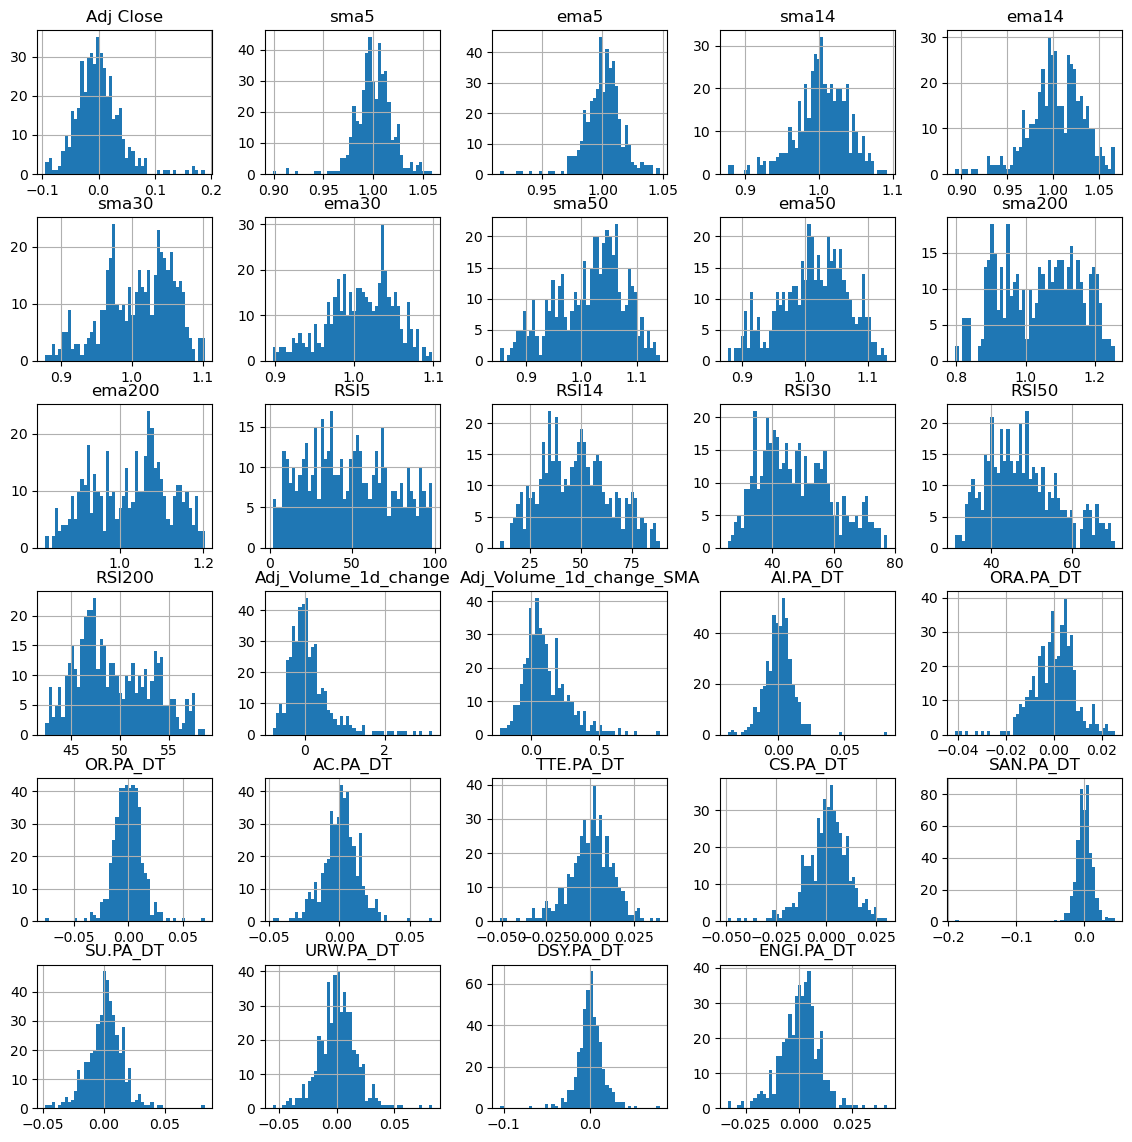

In [62]:
clean_dataset.hist(
    bins=50, 
    sharex=False, 
    sharey=False, 
    figsize=(14,14)
)

plt.show()

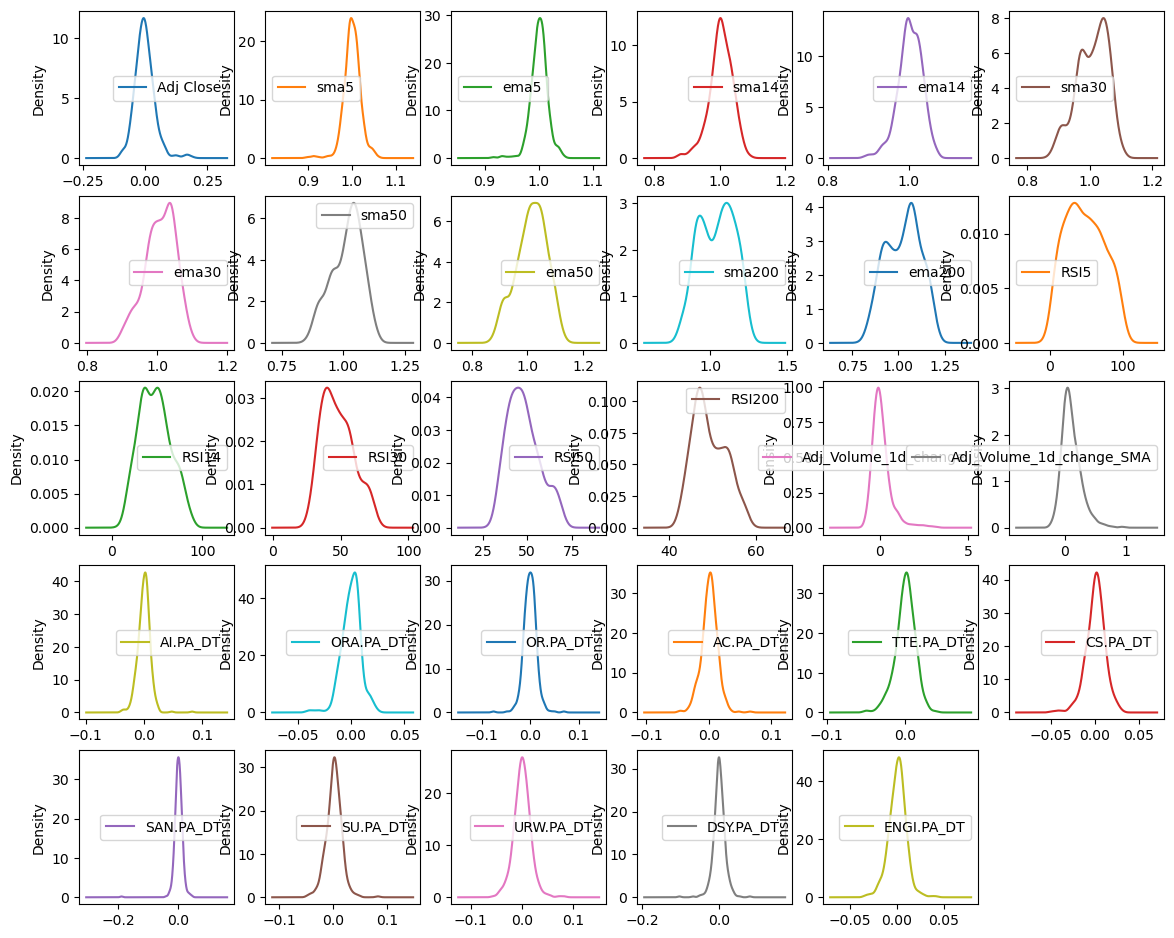

In [63]:
clean_dataset.plot(
    kind = 'density',
    subplots = True,
    layout=(6,6),
    sharex=False, 
    sharey=False, 
    legend = True,
    figsize=(14,14)
)

plt.show()

# Modelisation

In [98]:
# Données d'entraînement et de test

y = clean_dataset['LVMH_5d_close_future_pct']

X = clean_dataset.drop('LVMH_5d_close_future_pct', axis = 1)

validation_size = 0.25

train_size = int(len(X) * (1-validation_size))

X_train, X_test = X[0:train_size], X[train_size:len(X)]

Y_train, Y_test = y[0:train_size], y[train_size:len(X)]

In [99]:
 #Liste des algorithmes à entraîner

seed = 123

models = []

models.append(('LR', {'model':LinearRegression()}))
models.append(('LASSO', {'model':Lasso()}))
models.append(('EN', {'model':ElasticNet()}))
models.append(('KNN', {'model':KNeighborsRegressor()}))
models.append(('CART', {'model':DecisionTreeRegressor(random_state = seed)}))
models.append(('SVR', {'model':SVR()}))

models.append(('MLP', {'model':MLPRegressor(random_state = seed)}))

models.append(('ABR', {'model':AdaBoostRegressor(random_state = seed)}))
models.append(('XGBOOST', {'model':XGBRegressor(random_state=seed)}))
models.append(('GBR', {'model':GradientBoostingRegressor(random_state = seed)}))

models.append(('RFR', {'model':RandomForestRegressor(random_state = seed)}))
models.append(('ETR', {'model':ExtraTreesRegressor(random_state = seed)}))

In [100]:
algos_ml = dict(models)
algos_ml

{'LR': {'model': LinearRegression()},
 'LASSO': {'model': Lasso()},
 'EN': {'model': ElasticNet()},
 'KNN': {'model': KNeighborsRegressor()},
 'CART': {'model': DecisionTreeRegressor(random_state=123)},
 'SVR': {'model': SVR()},
 'MLP': {'model': MLPRegressor(random_state=123)},
 'ABR': {'model': AdaBoostRegressor(random_state=123)},
 'XGBOOST': {'model': XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
      

In [102]:
# Nombre de plis pour la validation croisée
num_folds = 5

# Métrique utilisée pour l'évaluation : Erreur quadratique moyenne négative
scoring = 'neg_mean_squared_error'

# Liste pour stocker les résultats de validation croisée pour chaque modèle
kfold_results = []

# Parcours de chaque algorithme dans le dictionnaire algos_ml
for model_name in algos_ml.keys():
    # Initialisation de la validation croisée KFold
    kfold = KFold(n_splits=num_folds)
    
    # Calcul des scores de validation croisée (MSE négatif), convertis en RMSE
    cv_results = np.sqrt(-1 * cross_val_score(
        algos_ml[model_name]['model'],  # Modèle à évaluer
        X_train,                        # Données d'entraînement (features)
        Y_train,                        # Données cibles (target)
        cv=kfold,                       # Stratégie de validation croisée
        scoring=scoring                 # Métrique utilisée (MSE négatif)
    ))
    
    # Stockage des résultats de validation croisée pour ce modèle
    kfold_results.append(cv_results)
    # Calcul de la moyenne et de l'écart-type des résultats de validation croisée
    algos_ml[model_name]['Mean CV results'] = cv_results.mean()
    algos_ml[model_name]['Std CV results'] = cv_results.std()
    # Entraînement du modèle sur les données d'entraînement complètes
    fitted_model = algos_ml[model_name]['model'].fit(X_train, Y_train)
    
    # Calcul des métriques d'évaluation sur l'ensemble d'entraînement
    algos_ml[model_name]['RMSE train'] = np.sqrt(mean_squared_error(
        Y_train,                        # Cibles réelles (entraînement)
        fitted_model.predict(X_train)  # Prédictions du modèle
    ))
    # Calcul des métriques d'évaluation sur l'ensemble de test
    algos_ml[model_name]['RMSE test'] = np.sqrt(mean_squared_error(
        Y_test,                         # Cibles réelles (test)
        fitted_model.predict(X_test)   # Prédictions du modèle
    ))
    # Calcul du coefficient de détermination (R²) sur l'ensemble d'entraînement
    algos_ml[model_name]['R² train'] = r2_score(
        Y_train,                        # Cibles réelles (entraînement)
        fitted_model.predict(X_train)  # Prédictions du modèle
    )
    # Calcul du coefficient de détermination (R²) sur l'ensemble de test
    algos_ml[model_name]['R² test'] = r2_score(
        Y_test,                         # Cibles réelles (test)
        fitted_model.predict(X_test)   # Prédictions du modèle
    )


In [106]:
results_metrics = pd.DataFrame.from_dict(
    algos_ml, 
    'index')[['RMSE train', 'RMSE test', 'Mean CV results', 'Std CV results', 'R² train', 'R² test']]

with pd.option_context('display.precision', 3):
    best_print = results_metrics.sort_values(by='RMSE test', ascending=True)

best_print


,RMSE train,RMSE test,Mean CV results,Std CV results,R² train,R² test
RFR,1.221837e-02,0.047276,0.035895,0.013811,0.884997,0.009546
ABR,2.360655e-02,0.047376,0.036138,0.011716,0.570712,0.005332
GBR,1.340555e-02,0.047623,0.039069,0.014581,0.861563,-0.005086
LASSO,3.602951e-02,0.048240,0.035079,0.010380,0.000000,-0.031255
EN,3.602951e-02,0.048240,0.035079,0.010380,0.000000,-0.031255
KNN,2.911968e-02,0.048645,0.039698,0.011475,0.346784,-0.048681
ETR,6.279446e-17,0.049230,0.037744,0.014698,1.000000,-0.074020
LR,3.150286e-02,0.051782,0.053828,0.020400,0.235490,-0.188279
SVR,4.738047e-02,0.052676,0.049927,0.009820,-0.729347,-0.229653
XGBOOST,6.581409e-04,0.052908,0.039803,0.013486,0.999666,-0.240499


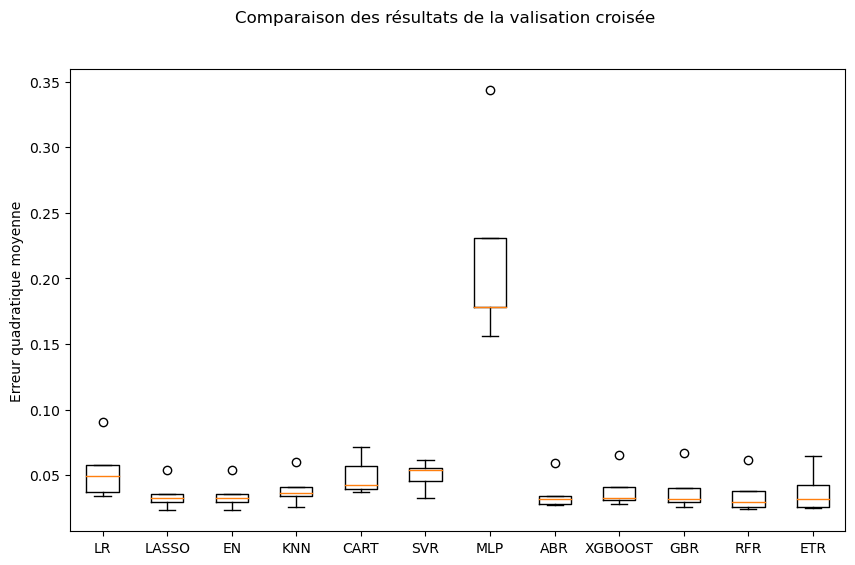

In [107]:
# Comparaison des résultats de la valisation croisée

fig = plt.figure()
fig.suptitle('Comparaison des résultats de la valisation croisée')
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(list(algos_ml.keys()))
fig.set_size_inches(10,6)
plt.ylabel('Erreur quadratique moyenne')
plt.show()

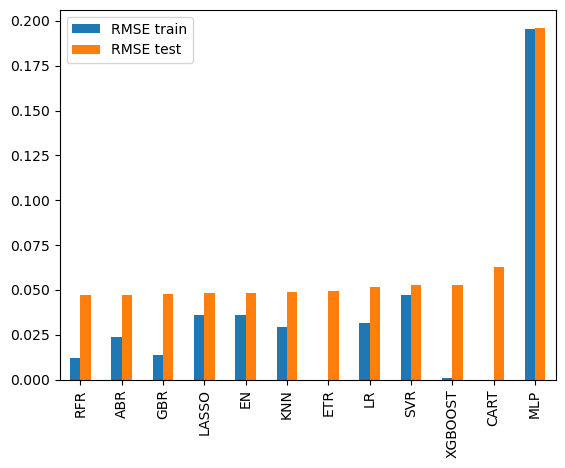

In [108]:
# Comparaison des Erreurs d'entraînement et de test pour tous les modèles

best_print[['RMSE train', 'RMSE test']].plot(kind = 'bar');

In [138]:
# Modèle final

best_model = algos_ml['LR']['model']
best_model

LinearRegression()

In [139]:
# Fonction d'évaluation du modèle

def evaluate_model(nom_model, predictions):
    plt.figure(figsize = (10, 6))
    l1, = plt.plot(Y_test.index, np.exp(Y_test).cumprod(), label = 'Observation')
    l2, = plt.plot(Y_test.index, predictions, label = 'Prediction')
    plt.legend(handles = [l1, l2])
    plt.show()

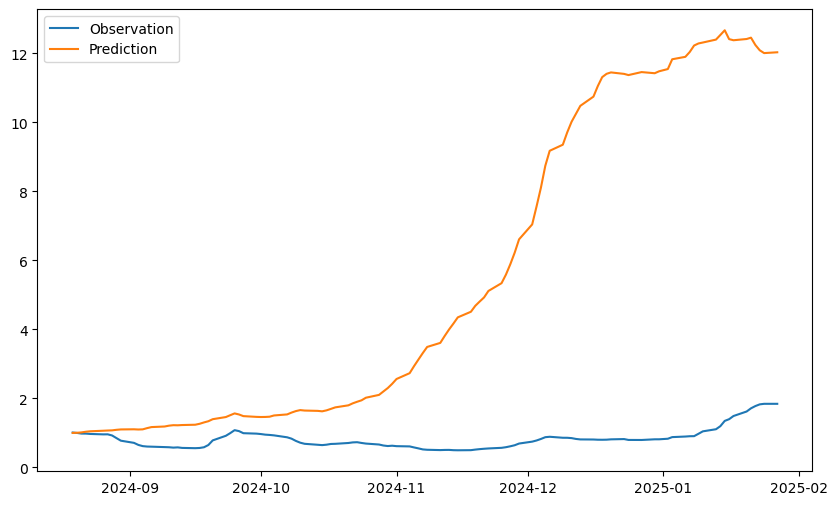

In [140]:
evaluate_model(best_model, predictions = np.exp(best_model.predict(X_test)).cumprod())

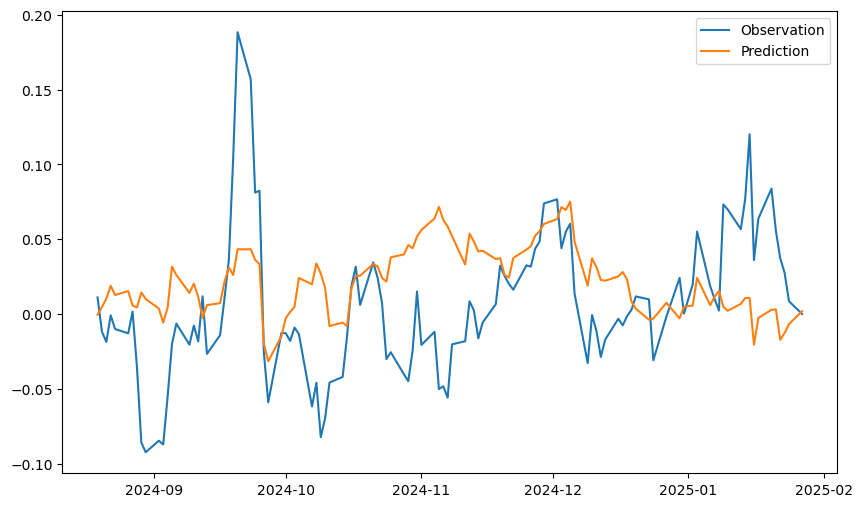

In [141]:
plt.figure(figsize = (10, 6))
l1, = plt.plot(Y_test.index, Y_test, label = 'Observation')
l2, = plt.plot(Y_test.index, best_model.predict(X_test), label = 'Prediction')
plt.legend(handles = [l1, l2])
plt.show()